In [1]:
# -----------------------------
# Imports & Setup
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import sys


project_root = Path.cwd().resolve().parent 
sys.path.append(str(project_root))

from src.data.loader import IPCountryLoader, FraudDataLoader
from src.data.merger import GeoDataMerger
from src.utils.io_utils import save_dataframe

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 50)

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("EDA_Fraud_Geo")


In [2]:
fraud_loader = FraudDataLoader("../data/processed/fraud_data_cleaned.csv")
fraud_df = fraud_loader.load()

ip_loader = IPCountryLoader("../data/raw/IpAddress_to_Country.csv")
ip_df = ip_loader.load()

logger.info(f"Cleaned fraud data shape: {fraud_df.shape}")
logger.info(f"IP-to-country data shape: {ip_df.shape}")

logger.info(f"IP-to-country data columns: {ip_df.columns}")


2025-12-21 11:28:20,625 [INFO] Cleaned fraud data shape: (151112, 11)
2025-12-21 11:28:20,627 [INFO] IP-to-country data shape: (138846, 3)
2025-12-21 11:28:20,631 [INFO] IP-to-country data columns: Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')


In [3]:
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
# Check the format of IP addresses in fraud data
logger.info("IP Address column info:")
logger.info(f"  Data type: {fraud_df['ip_address'].dtype}")
logger.info("Sample Values:\n" )
fraud_df['ip_address'].head(10)


2025-12-21 11:28:20,691 [INFO] IP Address column info:
2025-12-21 11:28:20,691 [INFO]   Data type: float64
2025-12-21 11:28:20,693 [INFO] Sample Values:



0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
5    2.809315e+09
6    3.987484e+09
7    1.692459e+09
8    3.719094e+09
9    3.416747e+08
Name: ip_address, dtype: float64

In [5]:
# Check the format of IP ranges in mapping data
logger.info("IP Range column info:")
logger.info(f"  Lower bound dtype: {ip_df['lower_bound_ip_address'].dtype}")
logger.info(f"  Upper bound dtype: {ip_df['upper_bound_ip_address'].dtype}")
logger.info("Sample IP ranges:\n" )
ip_df.head()


2025-12-21 11:28:20,720 [INFO] IP Range column info:
2025-12-21 11:28:20,722 [INFO]   Lower bound dtype: float64
2025-12-21 11:28:20,727 [INFO]   Upper bound dtype: int64
2025-12-21 11:28:20,727 [INFO] Sample IP ranges:



,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
# Check unique countries
num_countries = ip_df['country'].nunique()
logger.info(f"Number of unique countries: {num_countries}")

top_countries = ip_df['country'].value_counts().head(10)
logger.info("Top 10 countries by IP range count:\n" + top_countries.to_string())


2025-12-21 11:28:20,762 [INFO] Number of unique countries: 235
2025-12-21 11:28:20,774 [INFO] Top 10 countries by IP range count:
country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
United Kingdom         5401
Brazil                 4885
China                  3725
Poland                 3042
Japan                  3005


In [7]:
# -----------------------------
#  Basic Statistics
# -----------------------------
# Number of unique countries
num_countries = ip_df['country'].nunique()
logger.info(f"Number of unique countries: {num_countries}")




2025-12-21 11:28:20,797 [INFO] Number of unique countries: 235


In [8]:
# Total number of IP ranges
num_ranges = len(ip_df)
logger.info(f"Total IP ranges: {num_ranges}")

2025-12-21 11:28:20,809 [INFO] Total IP ranges: 138846


In [9]:
# Range size (upper - lower)
ip_df['range_size'] = ip_df['upper_bound_ip_address'] - ip_df['lower_bound_ip_address'] + 1
logger.info(f"IP range size stats:\n{ip_df['range_size'].describe()}")

2025-12-21 11:28:20,835 [INFO] IP range size stats:
count    1.388460e+05
mean     2.550070e+04
std      3.065619e+05
min      8.000000e+00
25%      2.560000e+02
50%      1.024000e+03
75%      8.192000e+03
max      1.677722e+07
Name: range_size, dtype: float64


In [10]:
geo_merger = GeoDataMerger(fraud_df, ip_df)


In [11]:
fraud_df_geo = geo_merger.merge_country()
logger.info("Merged country column into fraud data.")


2025-12-21 11:28:21,080 [INFO] Merged country column into fraud data.


In [12]:
fraud_df_geo[['ip_address','country','class']].head()


,ip_address,country,class
0,7.327584e+08,Japan,0
1,3.503114e+08,United States,0
2,2.621474e+09,United States,1
3,3.840542e+09,Unknown,0
4,4.155831e+08,United States,0


In [13]:
country_counts = fraud_df_geo['country'].value_counts()
unknown_count = (fraud_df_geo['country'] == 'Unknown').sum()

logger.info(f"Country mapping results:")
logger.info(f"  Total transactions: {len(fraud_df_geo):,}")
logger.info(f"  Mapped to country: {len(fraud_df_geo) - unknown_count:,}")
logger.info(f"  Unknown/Unmapped: {unknown_count:,} ({unknown_count/len(fraud_df_geo)*100:.2f}%)")
logger.info(f"  Unique countries: {fraud_df_geo['country'].nunique()}")

2025-12-21 11:28:21,173 [INFO] Country mapping results:
2025-12-21 11:28:21,173 [INFO]   Total transactions: 151,112
2025-12-21 11:28:21,175 [INFO]   Mapped to country: 129,146
2025-12-21 11:28:21,179 [INFO]   Unknown/Unmapped: 21,966 (14.54%)
2025-12-21 11:28:21,193 [INFO]   Unique countries: 182


In [14]:
country_summary = geo_merger.get_summary()
logger.info("Country summary computed.")
country_summary.head(10)


2025-12-21 11:28:21,239 [INFO] Country summary computed.


,country,total_transactions,fraud_count,fraud_rate
0,United States,58049,5551,0.095626
1,Unknown,21966,1883,0.085723
2,China,12038,1043,0.086642
3,Japan,7306,715,0.097865
4,United Kingdom,4490,477,0.106236
5,Korea Republic of,4162,380,0.091302
6,Canada,2975,348,0.116975
7,France,3161,300,0.094907
8,Brazil,2961,270,0.091185
9,Germany,3646,262,0.071860


In [15]:

# Countries with highest fraud rates (with minimum transaction count)
MIN_TRANSACTIONS = 100  # Filter out countries with too few transactions

country_stats_filtered = country_summary[country_summary['total_transactions'] >= MIN_TRANSACTIONS]
top_fraud_rate = country_stats_filtered.sort_values('fraud_rate', ascending=False).head(15)

print(f"\nTop 15 Countries by Fraud Rate (min {MIN_TRANSACTIONS} transactions):")
display(top_fraud_rate)


Top 15 Countries by Fraud Rate (min 100 transactions):


,country,total_transactions,fraud_count,fraud_rate
45,Ecuador,106,28,0.264151
44,Tunisia,118,31,0.262712
43,Peru,119,31,0.260504
29,Ireland,240,55,0.229167
25,New Zealand,278,62,0.223022
30,Saudi Arabia,264,50,0.189394
19,Denmark,490,78,0.159184
24,Chile,417,64,0.153477
40,Greece,231,33,0.142857
52,United Arab Emirates,114,16,0.140351


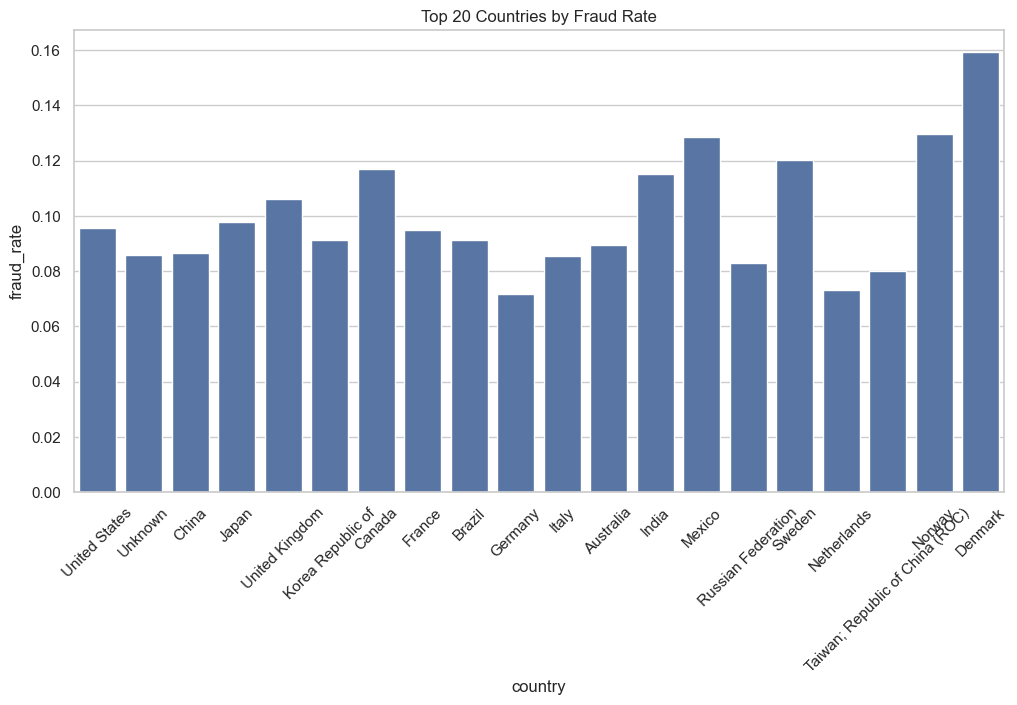

In [16]:
# -----------------------------
# 6️⃣ Visualize Fraud Patterns by Country
# -----------------------------
# Top 20 countries by fraud rate
top_countries_fraud = country_summary.sort_values(by='fraud_count', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x='country', y='fraud_rate', data=top_countries_fraud)
plt.title("Top 20 Countries by Fraud Rate")
plt.xticks(rotation=45)
plt.show()




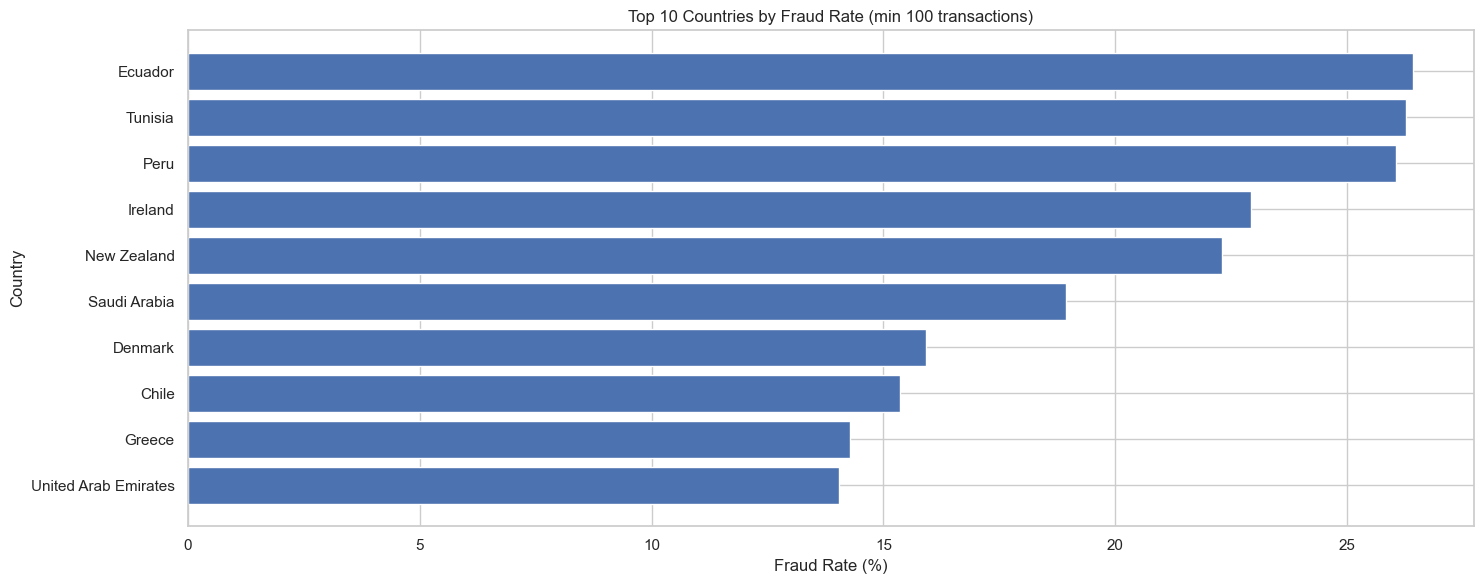

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

top_by_rate = (
    country_stats_filtered
    .sort_values(by='fraud_rate', ascending=False)
    .head(10)
)

ax.barh(
    top_by_rate['country'],
    top_by_rate['fraud_rate'] * 100
)

ax.set_xlabel('Fraud Rate (%)')
ax.set_ylabel('Country')
ax.set_title(f'Top 10 Countries by Fraud Rate (min {MIN_TRANSACTIONS} transactions)')
ax.invert_yaxis()

plt.tight_layout()
plt.show()


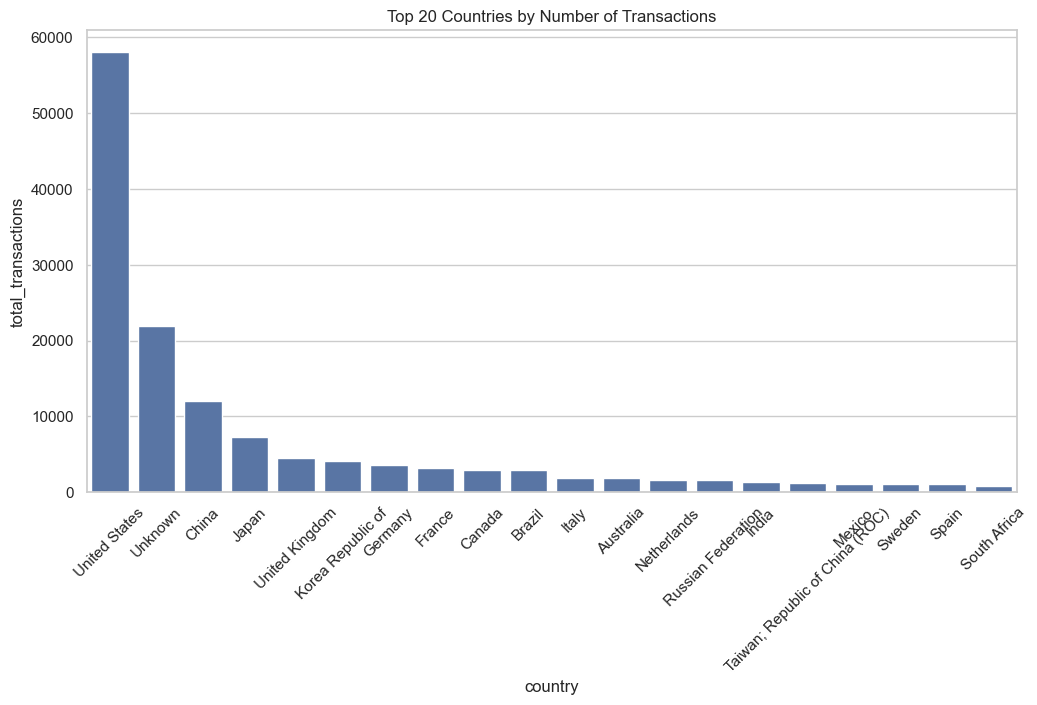

In [18]:
# Top 20 countries by number of transactions
top_countries_tx = country_summary.sort_values(by='total_transactions', ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(x='country', y='total_transactions', data=top_countries_tx)
plt.title("Top 20 Countries by Number of Transactions")
plt.xticks(rotation=45)
plt.show()

In [19]:
save_dataframe(fraud_df_geo, "../data/processed/fraud_data_with_country.csv")
logger.info("Cleaned fraud data saved to processed folder.")

2025-12-21 11:28:25,228 [INFO] Cleaned fraud data saved to processed folder.


[IO] Data saved to ..\data\processed\fraud_data_with_country.csv
